In [2]:
import pandas as pd
from sklearn.datasets import fetch_covtype
import numpy as np
from tqdm import tqdm
from typing import List, Tuple, Callable, Dict, Any
import copy

from src.data.datasets import get_dataset
from src.models.networks import get_mlp, get_autoencoder
import torchvision.transforms as transforms
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from src.data.contamination import get_contaminated_stream

import itertools 


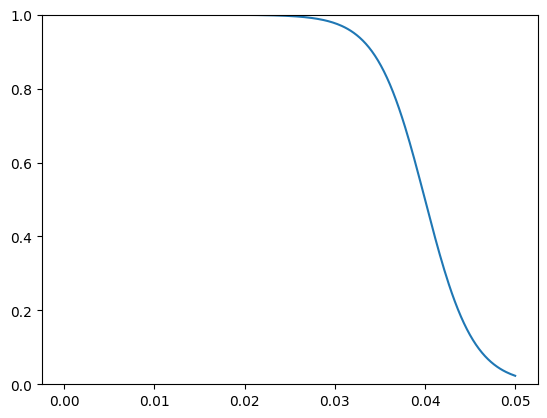

In [6]:
threshold = .04
steepness = 15 / threshold
x = np.linspace(0, 0.05, 300)
y = 1 / (1 + np.exp(steepness * (x - threshold)))
fig, ax = plt.subplots()
ax.set_ylim(0, 1)
ax.plot(x, y)


In [7]:
x, y = get_dataset("Insects abrupt")
pd.Series(y).value_counts()

ae-albopictus-female    8808
cx-quinq-female         8808
ae-aegypti-male         8808
cx-quinq-male           8808
ae-aegypti-female       8808
ae-albopictus-male      8808
Name: count, dtype: int64

In [2]:
df = pd.read_json(
    "../reports/contam_filtering_grid.jsonl", lines=True, orient="records"
)
df["preds"] = df["preds"].apply(np.array)
df["labels"] = df["labels"].apply(np.array)
df["loss_weights"] = df["loss_weights"].apply(np.array)
df["is_anom_pred"] = df["loss_weights"].apply(lambda row: ~(row.astype(bool)))
df["is_anom"] = df["is_anom"].apply(np.array)

df["accuracy"] = df.apply(
    lambda row: (row["preds"] == row["labels"])[~row["is_anom"]].mean() * 100, axis=1
)

parameters = ["p_anomaly", "len_anomaly", "steepness", "threshold_quantile"]
dfm = df.groupby(parameters)['accuracy'].mean()
dfm

p_anomaly  len_anomaly  steepness  threshold_quantile
0.02       2            0.0        0.9000                92.067212
                                   0.9500                92.067212
                                   0.9750                92.067212
                                   0.9875                92.067212
                        15.0       0.9000                91.667355
                                   0.9500                91.832398
                                   0.9750                91.808985
                                   0.9875                91.980976
                        30.0       0.9000                91.219055
                                   0.9500                91.391744
                                   0.9750                91.509958
                                   0.9875                91.832617
                        60.0       0.9000                90.815035
                                   0.9500                91.115441
        

In [5]:
dfr = dfm.reset_index()
idcs = dfr.groupby(['p_anomaly'])['accuracy'].idxmax()
dfr.loc[idcs]

,p_anomaly,len_anomaly,steepness,threshold_quantile,accuracy
0,0.02,2,0.0,0.900,92.067212
26,0.04,2,15.0,0.975,92.216133
46,0.08,2,15.0,0.975,92.177670


In [3]:
df = pd.read_json("../reports/contamination_insects.jsonl", lines=True, orient="records")

df["preds"] = df["preds"].apply(np.array)
df["labels"] = df["labels"].apply(np.array)
df["is_anom"] = df["is_anom"].apply(np.array)

df["accuracy"] = df.apply(
    lambda row: (row["preds"] == row["labels"])[~row["is_anom"]].mean() * 100, axis=1
)
parameters = ["anomaly_type", "p_anomaly", "len_anomaly"]

dfm = df.groupby(parameters)["accuracy"].agg(["mean", "std"])
dfm = dfm.reset_index()
dfm

,anomaly_type,p_anomaly,len_anomaly,mean,std
0,label_flip,0.00,2,97.939293,0.039319
1,label_flip,0.00,4,97.939293,0.039319
2,label_flip,0.00,8,97.939293,0.039319
3,label_flip,0.00,16,97.939293,0.039319
4,label_flip,0.02,2,97.613131,0.052641
5,label_flip,0.02,4,97.593095,0.086701
6,label_flip,0.02,8,97.586883,0.125584
7,label_flip,0.02,16,97.606530,0.102567
8,label_flip,0.04,2,97.326720,0.089413
9,label_flip,0.04,4,97.261071,0.150874


In [15]:
df = pd.read_json("../reports/contamination_rmnist.jsonl", lines=True, orient="records")

df["preds"] = df["preds"].apply(np.array)
df["labels"] = df["labels"].apply(np.array)
df["is_anom"] = df["is_anom"].apply(np.array)

df["accuracy"] = df.apply(
    lambda row: (row["preds"] == row["labels"])[~row["is_anom"]].mean() * 100, axis=1
)
parameters = ["anomaly_type", "p_anomaly", "len_anomaly"]

dfm = df.groupby(parameters)["accuracy"].agg(["mean", "std"])
dfm = dfm.reset_index()

In [13]:
df = pd.read_json("../reports/contamination2.jsonl", lines=True, orient="records")

df["preds"] = df["preds"].apply(np.array)
df["labels"] = df["labels"].apply(np.array)
df["is_anom"] = df["is_anom"].apply(np.array)

df["accuracy"] = df.apply(
    lambda row: (row["preds"] == row["labels"])[~row["is_anom"]].mean() * 100, axis=1
)
parameters = ["anomaly_type", "p_anomaly", "len_anomaly"]

dfm = df.groupby(parameters)["accuracy"].agg(["mean", "std"])
dfm = dfm.reset_index()

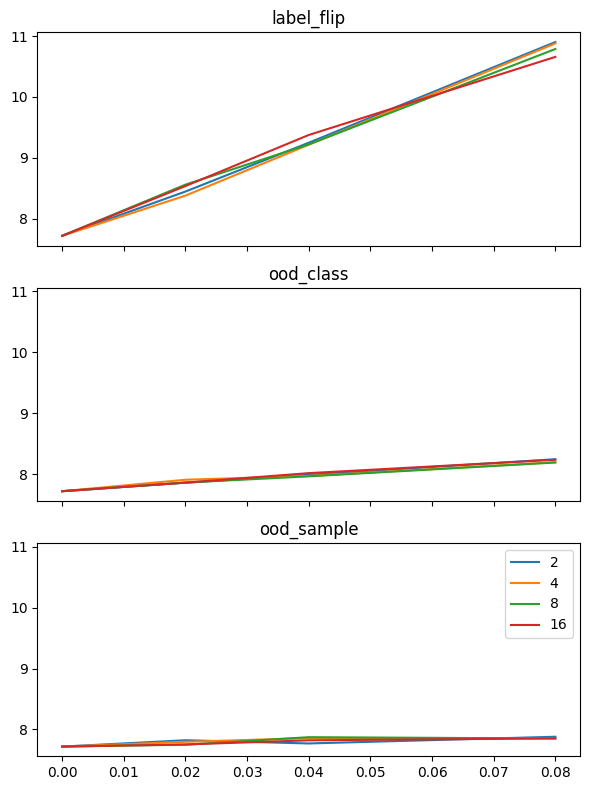

In [17]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 8), sharex=True, sharey=True)

for ax, (anom_type, df_anom_type) in zip(axs, dfm.groupby("anomaly_type")):
    ax.set_title(anom_type)
    for len_anomaly, df_len_anomaly in df_anom_type.groupby("len_anomaly"):
        ax.plot(df_len_anomaly["p_anomaly"], 100-df_len_anomaly["mean"], label=len_anomaly)
        # ax.errorbar(
        #     df_len_anomaly["p_anomaly"],
        #     df_len_anomaly["mean"],
        #     yerr=df_len_anomaly["std"],
        #     fmt="o",
        #     capsize=3,
        # )

ax.legend()
fig.tight_layout()

In [28]:
df = pd.read_json("../reports/tune_full_rmnist.jsonl", orient='records', lines=True)
hparams = ['lr', 'n_hidden_layers', "n_hidden_units"]
df['accuracy'] = df.apply(lambda row: (np.array(row['preds']) == np.array(row['labels'])).mean(), axis=1)
df[hparams + ['accuracy']].sort_values(by='accuracy', ascending=False)

,lr,n_hidden_layers,n_hidden_units,accuracy
95,0.03125,1,1024,0.9192
77,0.03125,1,512,0.9112
59,0.03125,1,256,0.9074
41,0.03125,1,128,0.9018
94,0.06250,1,1024,0.8976
...,...,...,...,...
24,1.00000,2,64,0.1066
54,1.00000,1,256,0.1066
66,1.00000,3,256,0.1066
36,1.00000,1,128,0.1064


In [13]:
files = ['tune_full2', 'tune_full_rmnist', 'tune_full_insects']
datasets = ['Covertype', 'Rotated MNIST', 'Insects abrupt']

dfs = []
for fname, dname in zip(files, datasets):
    dfi = pd.read_json(f"../reports/{fname}.jsonl", orient='records', lines=True) 
    dfi['dataset'] = dname
    dfs.append(dfi)
df_all = pd.concat(dfs)
df_all.to_json("../reports/tune_clf.jsonl", orient='records', lines=True, index=False)


In [16]:

df = pd.read_json("../reports/tune_clf.jsonl", orient='records', lines=True)
hparams = ['dataset', 'lr', 'n_hidden_layers', "n_hidden_units"]
df['accuracy'] = df.apply(lambda row: (np.array(row['preds']) == np.array(row['labels'])).mean(), axis=1)
idcs_best = df.groupby('dataset')['accuracy'].idxmax()
df.loc[idcs_best][hparams + ['accuracy']]

,dataset,lr,n_hidden_layers,n_hidden_units,accuracy
95,Covertype,0.03125,1,1024,0.7096
238,Insects abrupt,0.06250,1,1024,0.9726
203,Rotated MNIST,0.03125,1,1024,0.9192


In [45]:
df = pd.read_json("../reports/ae_tune.jsonl", orient='records', lines=True)
hparams = ['dataset', 'lr', 'n_hidden_layers', "n_hidden_units", 'dropout', 'epochs']

df['anom_scores']= df['anom_scores'].apply(np.array)
df['is_anom']= df['is_anom'].apply(np.array)

df['roc_auc'] = df.apply(lambda row: roc_auc_score(row['is_anom'], row['anom_scores']), axis=1)
idcs_max = df.groupby('dataset')['roc_auc'].idxmax()
df.loc[idcs_max][hparams + ['roc_auc']]

,dataset,lr,n_hidden_layers,n_hidden_units,dropout,epochs,roc_auc
0,Covertype,1.00,1,64,0.0,8,1.000000
278,Insects abrupt,0.25,2,512,0.0,8,0.727738
169,Rotated MNIST,1.00,2,512,0.0,8,0.704462
